# Abalone

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from a pandas dataframe by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

## Create Datasets

In [3]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed"

    },
}

In [4]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict = dd.read(dd_dict)

root dir set to None


`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## Specify the Model

In [5]:
# %load_ext autoreload
# %autoreload 2
# import yeahml as yml

In [15]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

In [16]:
yml_dict

{'meta': {'yeahml_dir': 'yeahml',
  'data_name': 'mnist',
  'experiment_name': 'trial_00',
  'rand_seed': None,
  'trace_level': None,
  'default_load_params_path': None},
 'logging': {'console': {'level': 'info',
   'format_str': '%(name)-12s: %(levelname)-8s %(message)s'},
  'file': {'level': 'error',
   'format_str': '%(filename)s:%(lineno)s - %(funcName)20s()][%(levelname)-8s]: %(message)s'}},
 'performance': {'objectives': {'main_obj': {'loss': {'type': 'categorical_crossentropy',
     'options': None,
     'track': ['mean']},
    'metric': {'type': ['categoricalaccuracy'], 'options': [None]},
    'in_config': {'type': 'supervised',
     'options': {'prediction': 'y_pred', 'target': 'y_target'}}},
   'second_obj': {'loss': {'type': 'categorical_crossentropy',
     'options': None,
     'track': ['mean']},
    'metric': {'type': ['topkcategoricalaccuracy', 'topkcategoricalaccuracy'],
     'options': [{'k': 2}, {'k': 3}]},
    'in_config': {'type': 'supervised',
     'options': {'pr

In [17]:
# import pprint
# pprint.pprint(yml_dict['hyper_parameters'])
# pprint.pprint(yml_dict['optimize'])
# pprint.pprint(yml_dict['performance'])

## Build the model

In [18]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_image (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv_2_downsample (Conv2D)   (None, 14, 14, 8)         584       
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 8)         584       
_________________________________________________________________
conv_4_downsample (Conv2D)   (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576 

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [21]:
# import pprint
# pprint.pprint(yml_dict['optimize'])
# print("--")
# pprint.pprint(yml_dict['performance'])
ds_dict = {"train": tf.data.Dataset.from_tensor_slices([1, 2, 3]) , "val": tf.data.Dataset.from_tensor_slices([1, 2, 3]) }

In [25]:
train_dict = yml.train_model(model, yml_dict, (ds_dict["train"], ds_dict["val"]))

train_logger: INFO     -> START training graph


{'main_opt': {'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb840064ba8>, 'objectives': ['main_obj']}}
************************************************
{'main_obj': {'in_config': {'type': 'supervised', 'options': {'prediction': 'y_pred', 'target': 'y_target'}}, 'loss': {'object': <function categorical_crossentropy at 0x7fb870fe1158>, 'track': {'train': {'categorical_crossentropy': {'mean': <tensorflow.python.keras.metrics.Mean object at 0x7fb840064fd0>}}, 'val': {'categorical_crossentropy': {'mean': <tensorflow.python.keras.metrics.Mean object at 0x7fb840064c18>}}}}, 'metrics': {'categoricalaccuracy': {'train': <tensorflow.python.keras.metrics.CategoricalAccuracy object at 0x7fb840064a20>, 'val': <tensorflow.python.keras.metrics.CategoricalAccuracy object at 0x7fb840072e10>}}}, 'second_obj': {'in_config': {'type': 'supervised', 'options': {'prediction': 'y_pred', 'target': 'y_target'}}, 'loss': {'object': <function categorical_crossentropy at 0x7fb870fe1158>

NameError: name 'sys' is not defined

In [6]:
print(train_dict["loss"]['main_obj']['train']['mean'])

NameError: name 'train_dict' is not defined

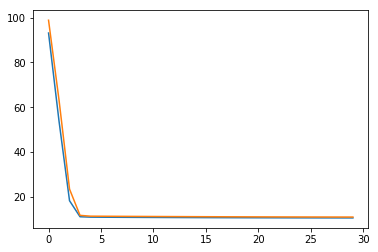

In [27]:
plt.plot(train_dict["loss"]['main_obj']['val']['mean'].values)
plt.plot(train_dict["loss"]['main_obj']['train']['mean'].values)

In [25]:
import matplotlib.pyplot as plt

In [16]:
# plt.plot(train_dict['joint']["main_obj__second_obj__joint_train"]["train"]["mean"]["epoch"]["values"])
# plt.plot(train_dict['joint']["main_obj__second_obj__joint_train"]["val"]["mean"]["epoch"]["values"])

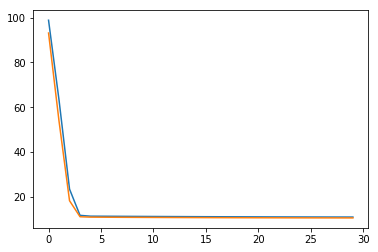

In [17]:
plt.plot(train_dict["loss"]["main_obj"]['train']["mean"]["epoch"]["values"])
plt.plot(train_dict["loss"]["main_obj"]['val']["mean"]["epoch"]["values"])

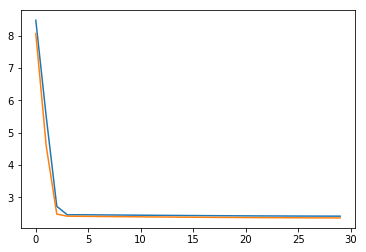

In [18]:
plt.plot(train_dict["loss"]["second_obj"]['train']["mean"]["epoch"]["values"])
plt.plot(train_dict["loss"]["second_obj"]['val']["mean"]["epoch"]["values"])

## Evaluate the Model

In [18]:
eval_dict = yml.eval_model(
    model,
    yml_dict,
    dataset=ds_dict["test"]
)
print(eval_dict)

ValueError: specified path is neither an h5 path, nor a directory containing directories of h5: yeahml/abalone/trial_00/model/run_2020_03_15-14_02_15/save/params/best_params.h5

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```